# TESS

In [1]:
import numpy as np
import starry
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
import matplotlib.pyplot as plt
import theano.tensor as tt

starry.config.lazy = True
starry.config.quiet = True

In [2]:
# importing the data into arrays
# first column of the data file is phase data
TessPhaseHalf = np.loadtxt("GD356allTess.dat", usecols=(0))
TessPhase = np.concatenate((TessPhaseHalf, TessPhaseHalf+1))
# second column of the data file is flux data
TessFluxHalf = np.loadtxt("GD356allTess.dat", usecols=(1))
TessFlux = np.concatenate((TessFluxHalf+1, TessFluxHalf+1))
# third column of the data file is flux error
TessErrorHalf = np.loadtxt("GD356allTess.dat", usecols=(2))
TessError = np.concatenate((TessErrorHalf, TessErrorHalf))

In [3]:
def mean_data(Phase, Flux, Error, bins):

    Phase_split = np.array_split(Phase, bins)
    Flux_split = np.array_split(Flux, bins)
    Error_split = np.array_split(Error, bins)

    meanPhase = [] * bins
    meanFlux = [] * bins
    meanError = [] * bins

    for i in range(bins):

        meanPhase_i = np.mean(Phase_split[i])
        meanFlux_i = np.sum(Flux_split[i] / (Error_split[i]**2))/ np.sum(1/(Error_split[i]**2))

        meanError_i = np.sqrt(1/np.sum(1/(Error_split[i]**2)))

        meanPhase.append(meanPhase_i)
        meanFlux.append(meanFlux_i)
        meanError.append(meanError_i)
        
    return meanPhase, meanFlux, meanError

In [30]:
meanPhase, meanFlux, meanError = mean_data(TessPhase, TessFlux, TessError, 200)

TESS_flux = meanFlux
TESS_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

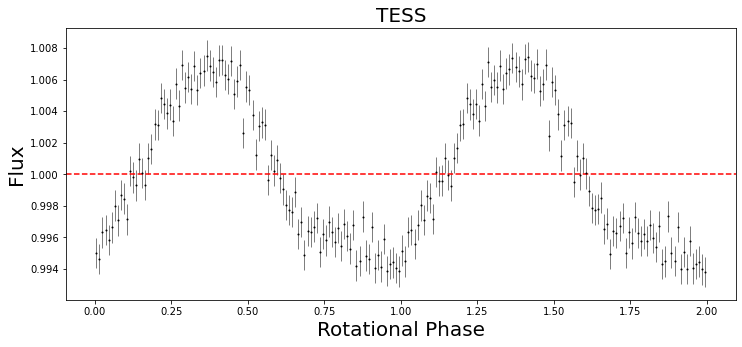

In [5]:
plt.figure(figsize=(12, 5))

plt.title('TESS', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, TESS_flux, yerr=TESS_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [9]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=0.04631, testval=0.04)
    radius = 35
    lat = pm.Uniform("lat", lower=0.0, upper=90.0, testval=0.1)
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = pm.Uniform("inc", lower=0.0, upper=90.0, testval=0.1)
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=TESS_flux_err, observed=TESS_flux)

In [10]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [inc, lon, lat, contrast]


message: Optimization terminated successfully.
logp: -932.2419851657946 -> 997.7899262861619


In [11]:
keys = ["contrast", "lat", "lon", "inc"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.04598
lat          50.64638
lon          45.30400
inc          39.35362


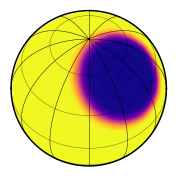

In [27]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.04598, radius=35, lat=50.64638, lon=45.30400)
map.inc = 39.35362
map.show()

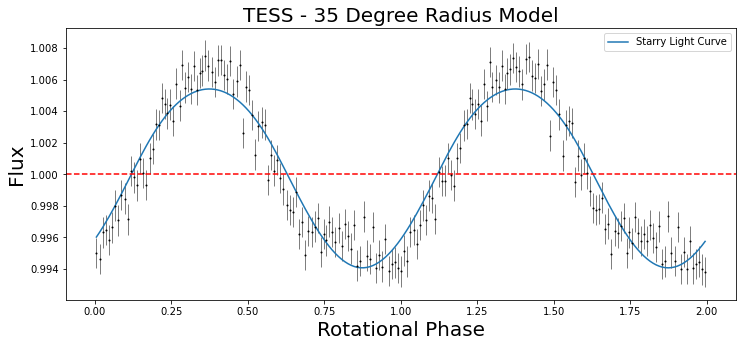

In [28]:
TESS_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('TESS - 35 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, TESS_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, TESS_flux, yerr=TESS_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [31]:
residuals = (TESS_flux - TESS_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

2.063838355938169

# LT

In [18]:
# importing the data into arrays
# first column of the data file is phase data
LTPhaseHalf = np.loadtxt("GD356LT.dat", usecols=(0))
LTPhase = np.concatenate((LTPhaseHalf, LTPhaseHalf+1))
# second column of the data file is flux data
LTFluxHalf = np.loadtxt("GD356LT.dat", usecols=(1))
LTFlux = np.concatenate((LTFluxHalf+1, LTFluxHalf+1))
# third column of the data file is flux error
LTErrorHalf = np.loadtxt("GD356LT.dat", usecols=(2))
LTError = np.concatenate((LTErrorHalf, LTErrorHalf))

In [19]:
meanPhase, meanFlux, meanError = mean_data(LTPhase, LTFlux, LTError, 200)

LT_flux = meanFlux
LT_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

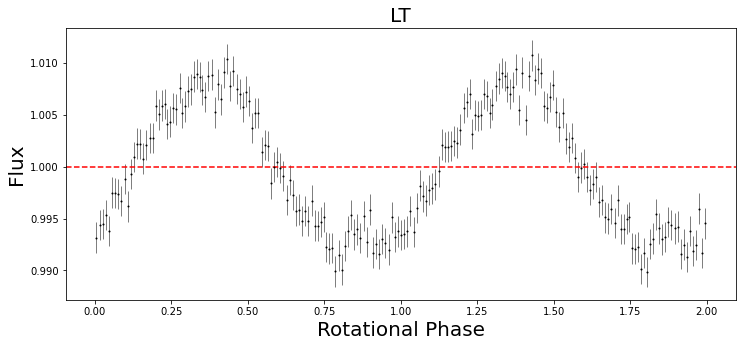

In [20]:
plt.figure(figsize=(12, 5))

plt.title('LT', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, LT_flux, yerr=LT_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [21]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.1)
    radius = 35
    lat = 50.64638
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 39.35362
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=LT_flux_err, observed=LT_flux)

In [22]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -1102.9806668241558 -> 1003.6675225949971


In [23]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.06449
lon          49.11455


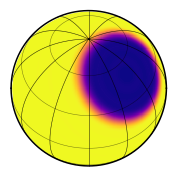

In [24]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.06449, radius=35, lat=50.64638, lon=49.11455)
map.inc = 39.35362
map.show()

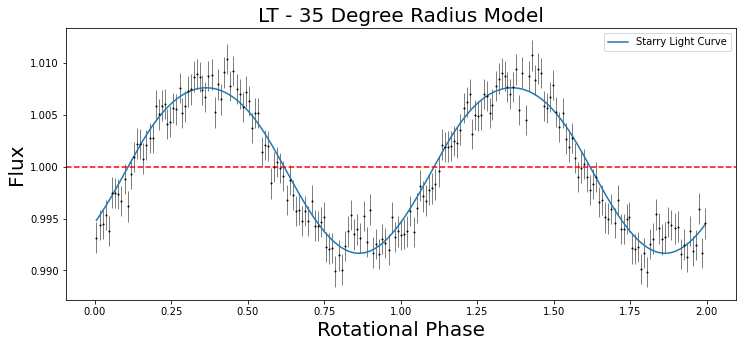

In [25]:
LT_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('LT - 35 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, LT_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, LT_flux, yerr=LT_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [26]:
residuals = (LT_flux - LT_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.186426495992064

# PTO

In [32]:
# importing the data into arrays
# first column of the data file is phase data
PTO_PhaseHalf = np.loadtxt("GD356PTO.dat", usecols=(0))
PTO_Phase = np.concatenate((PTO_PhaseHalf, PTO_PhaseHalf+1))
# second column of the data file is flux data
PTO_FluxHalf = np.loadtxt("GD356PTO.dat", usecols=(1))
PTO_Flux = np.concatenate((PTO_FluxHalf+1, PTO_FluxHalf+1))
# third column of the data file is flux error
PTO_ErrorHalf = np.loadtxt("GD356PTO.dat", usecols=(2))
PTO_Error = np.concatenate((PTO_ErrorHalf, PTO_ErrorHalf))

In [33]:
meanPhase, meanFlux, meanError = mean_data(PTO_Phase, PTO_Flux, PTO_Error, 200)

PTO_flux = meanFlux
PTO_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

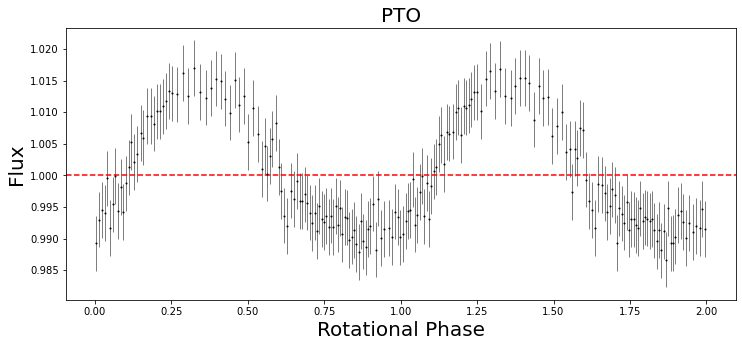

In [34]:
plt.figure(figsize=(12, 5))

plt.title('PTO', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, PTO_flux, yerr=PTO_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [35]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.1)
    radius = 35
    lat = 50.64638
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 39.35362
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=PTO_flux_err, observed=PTO_flux)

In [36]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: 536.2827448544216 -> 855.2057473049218


In [37]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.09434
lon          51.36381


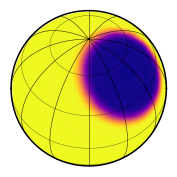

In [38]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.09434, radius=35, lat=50.64638, lon=51.36381)
map.inc = 39.35362
map.show()

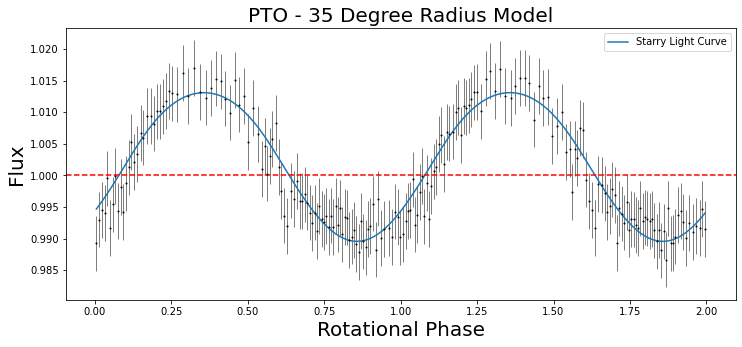

In [39]:
PTO_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('PTO - 35 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, PTO_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, PTO_flux, yerr=PTO_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [40]:
residuals = (PTO_flux - PTO_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

0.4314927914299488

# WHT

In [41]:
# importing the data into arrays
# first column of the data file is phase data
WHT_PhaseHalf = np.loadtxt("GD356WHT.dat", usecols=(0))
WHT_Phase = np.concatenate((WHT_PhaseHalf, WHT_PhaseHalf+1))
# second column of the data file is flux data
WHT_FluxHalf = np.loadtxt("GD356WHT.dat", usecols=(1))
WHT_Flux = np.concatenate((WHT_FluxHalf+1, WHT_FluxHalf+1))
# third column of the data file is flux error
WHT_ErrorHalf = np.loadtxt("GD356WHT.dat", usecols=(2))
WHT_Error = np.concatenate((WHT_ErrorHalf, WHT_ErrorHalf))

In [42]:
meanPhase, meanFlux, meanError = mean_data(WHT_Phase, WHT_Flux, WHT_Error, 200)

WHT_flux = meanFlux
WHT_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

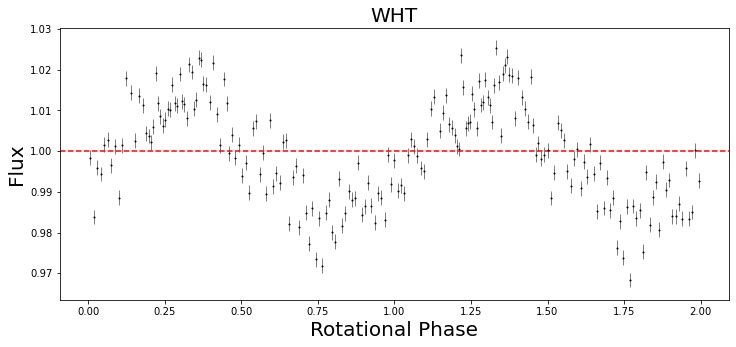

In [43]:
plt.figure(figsize=(12, 5))

plt.title('WHT', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, WHT_flux, yerr=WHT_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [44]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.1)
    radius = 35
    lat = 50.64638
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 39.35362
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=WHT_flux_err, observed=WHT_flux)

In [45]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -3617.998945265233 -> -103.41646789605834


In [46]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.11743
lon          68.74074


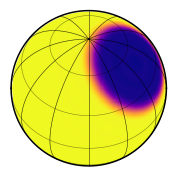

In [47]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.11743, radius=35, lat=50.64638, lon=68.74074)
map.inc = 39.35362
map.show()

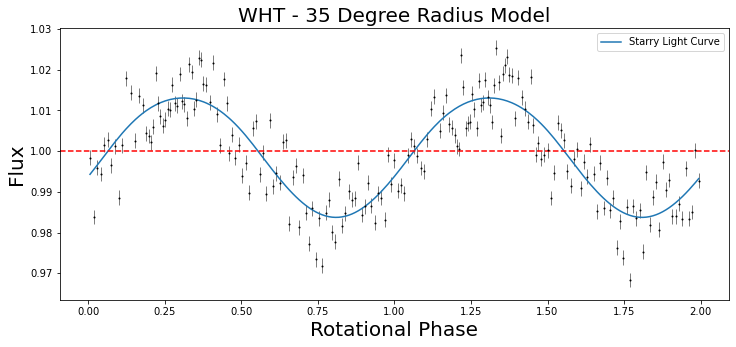

In [48]:
WHT_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('WHT - 35 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, WHT_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, WHT_flux, yerr=WHT_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [49]:
residuals = (WHT_flux - WHT_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

12.05406116333428

# ZTF-r

In [50]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356ZTFR.dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356ZTFR.dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

ZTFr_flux = meanFlux
ZTFr_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

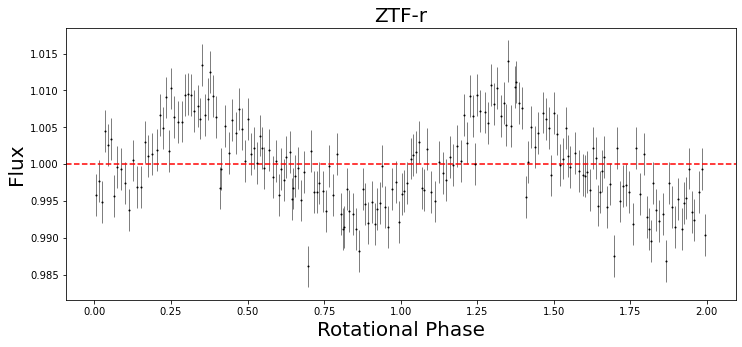

In [51]:
plt.figure(figsize=(12, 5))

plt.title('ZTF-r', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, ZTFr_flux, yerr=ZTFr_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [52]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.9999)
    radius = 35
    lat = 50.64638
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 39.35362
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=ZTFr_flux_err, observed=ZTFr_flux)

In [53]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -140368.13891413363 -> 844.6503654421062


In [54]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.05120
lon          54.70259


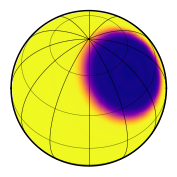

In [55]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.05120, radius=35, lat=50.64638, lon=54.70259)
map.inc = 39.35362
map.show()

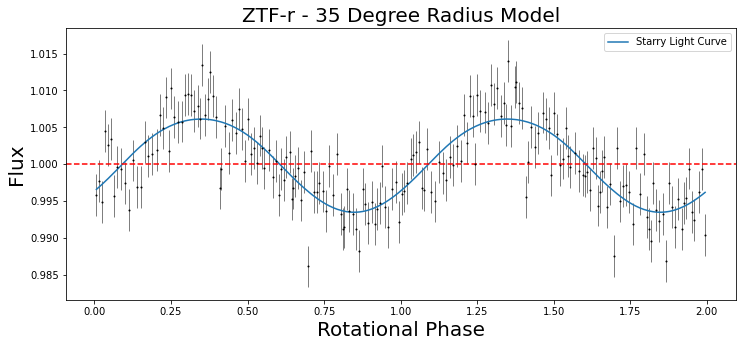

In [56]:
ZTFr_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('ZTF-r - 35 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, ZTFr_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, ZTFr_flux, yerr=ZTFr_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [57]:
residuals = (ZTFr_flux - ZTFr_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.4356526455867809

# ZTF-g

In [58]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356ZTFG.dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356ZTFG.dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

ZTFg_flux = meanFlux
ZTFg_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

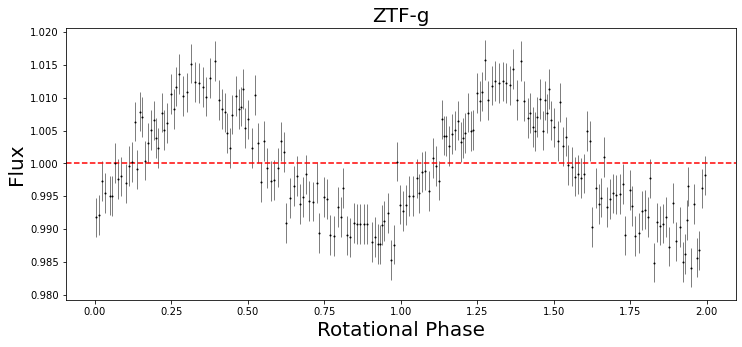

In [59]:
plt.figure(figsize=(12, 5))

plt.title('ZTF-g', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, ZTFg_flux, yerr=ZTFg_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [60]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.9999)
    radius = 35
    lat = 50.64638
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 39.35362
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=ZTFg_flux_err, observed=ZTFg_flux)

In [61]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -124162.32898869111 -> 865.2049651386156


In [62]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.08323
lon          53.33643


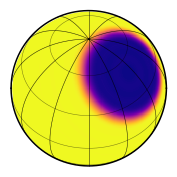

In [63]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.08323, radius=35, lat=50.64638, lon=53.33643)
map.inc = 39.35362
map.show()

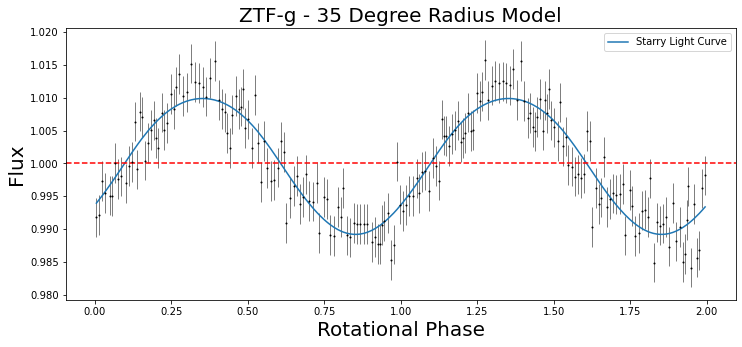

In [64]:
ZTFg_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('ZTF-g - 35 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, ZTFg_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, ZTFg_flux, yerr=ZTFg_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [65]:
residuals = (ZTFg_flux - ZTFg_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.098754933140363

# NUV

In [66]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTNUV.dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTNUV.dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

NUV_flux = meanFlux
NUV_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

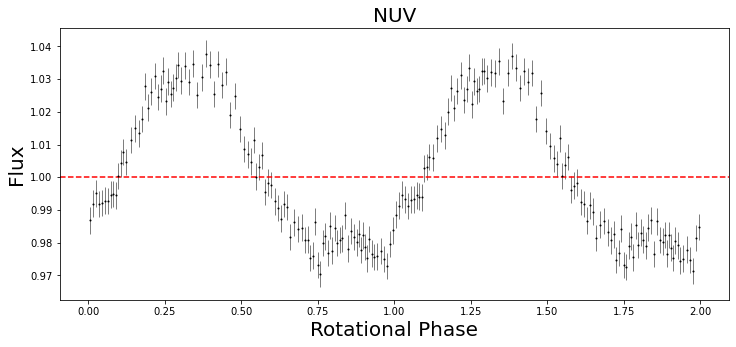

In [67]:
plt.figure(figsize=(12, 5))

plt.title('NUV', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV_flux, yerr=NUV_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [68]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.9999)
    radius = 35
    lat = 50.64638
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 39.35362
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=NUV_flux_err, observed=NUV_flux)

In [69]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -60495.51151094792 -> 721.761287442844


In [70]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.21353
lon          59.73605


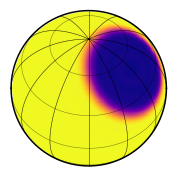

In [71]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.21353, radius=35, lat=50.64638, lon=59.73605)
map.inc = 39.35362
map.show()

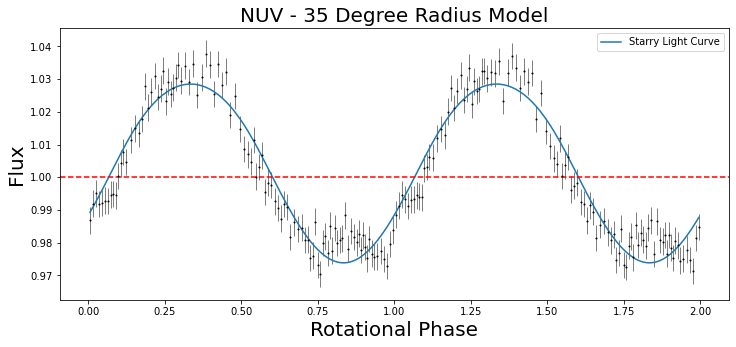

In [72]:
NUV_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('NUV - 35 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, NUV_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV_flux, yerr=NUV_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [73]:
residuals = (NUV_flux - NUV_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.9769635726152233

# NUV (2550 - 2950)

In [74]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTNUV(2550_2950).dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTNUV(2550_2950).dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

NUV3_flux = meanFlux
NUV3_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

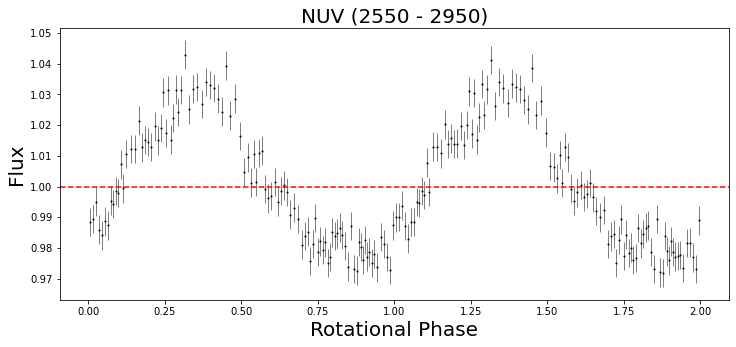

In [75]:
plt.figure(figsize=(12, 5))

plt.title('NUV (2550 - 2950)', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV3_flux, yerr=NUV3_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [76]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.9999)
    radius = 35
    lat = 50.64638
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 39.35362
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=NUV3_flux_err, observed=NUV3_flux)

In [77]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -44806.84188240786 -> 721.9536668438024


In [78]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.20186
lon          52.90630


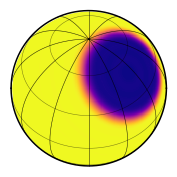

In [79]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.20186, radius=35, lat=50.64638, lon=52.90630)
map.inc = 39.35362
map.show()

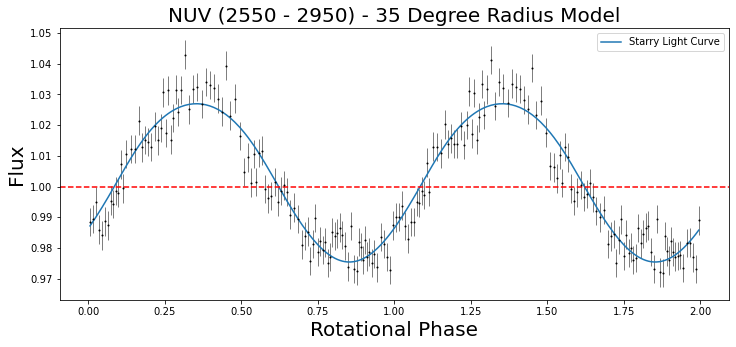

In [80]:
NUV3_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('NUV (2550 - 2950) - 35 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, NUV3_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV3_flux, yerr=NUV3_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [81]:
residuals = (NUV3_flux - NUV3_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.703572653031109

# NUV (2150 - 2550)

In [82]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTNUV(2150_2550).dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTNUV(2150_2550).dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

NUV2_flux = meanFlux
NUV2_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

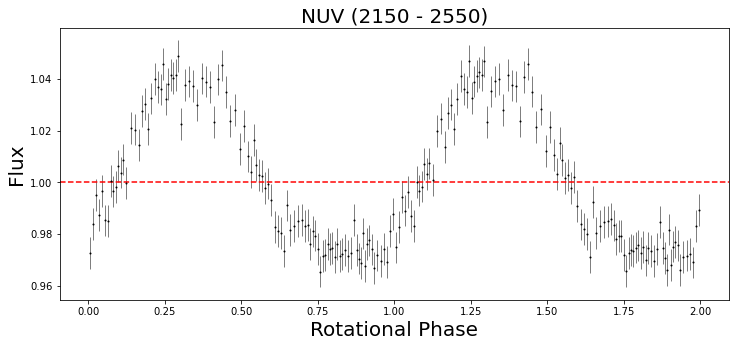

In [83]:
plt.figure(figsize=(12, 5))

plt.title('NUV (2150 - 2550)', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV2_flux, yerr=NUV2_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [84]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.9999)
    radius = 35
    lat = 50.64638
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 39.35362
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=NUV2_flux_err, observed=NUV2_flux)

In [85]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -25425.781322367176 -> 681.7071449740081


In [86]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.26473
lon          60.69998


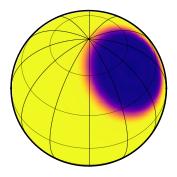

In [87]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.26473, radius=35, lat=50.64638, lon=60.69998)
map.inc = 39.35362
map.show()

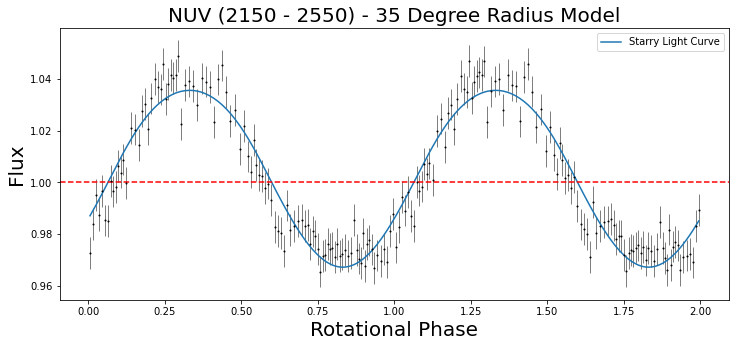

In [88]:
NUV2_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('NUV (2150 - 2550) - 35 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, NUV2_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV2_flux, yerr=NUV2_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [89]:
residuals = (NUV2_flux - NUV2_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.5385325674395902

# NUV (1630 - 2150)

In [90]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTNUV(1630_2150).dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTNUV(1630_2150).dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

NUV1_flux = meanFlux
NUV1_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

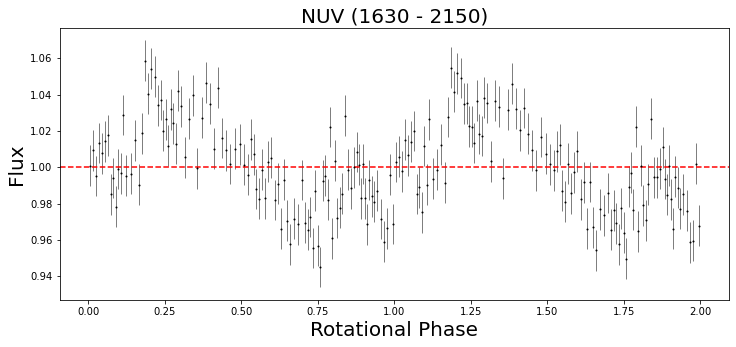

In [91]:
plt.figure(figsize=(12, 5))

plt.title('NUV (1630 - 2150)', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV1_flux, yerr=NUV1_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [92]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.9999)
    radius = 35
    lat = 50.64638
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 39.35362
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=NUV1_flux_err, observed=NUV1_flux)

In [93]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -8503.275443507098 -> 480.21697179761145


In [94]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.18969
lon          78.17489


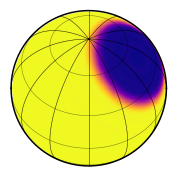

In [95]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.18969, radius=35, lat=50.64638, lon=78.17489)
map.inc = 39.35362
map.show()

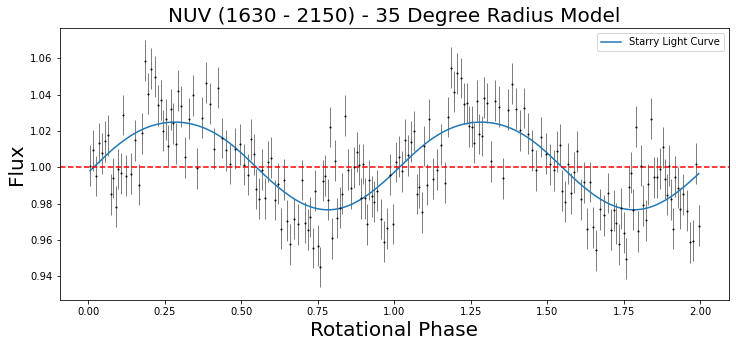

In [96]:
NUV1_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('NUV (1630 - 2150) - 35 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, NUV1_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV1_flux, yerr=NUV1_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [97]:
residuals = (NUV1_flux - NUV1_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

2.3613729052397376

# FUV

In [98]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTFUV.dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTFUV.dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

FUV_flux = meanFlux
FUV_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

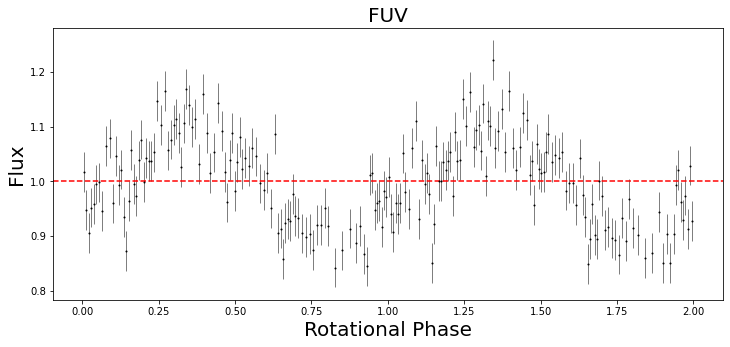

In [99]:
plt.figure(figsize=(12, 5))

plt.title('FUV', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV_flux, yerr=FUV_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [100]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.9999)
    radius = 35
    lat = 50.64638
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 39.35362
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=FUV_flux_err, observed=FUV_flux)

In [101]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -423.56656314144124 -> 289.9990586028947


In [102]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.65730
lon          58.43101


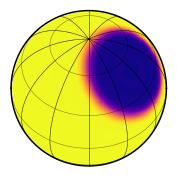

In [103]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.65730, radius=35, lat=50.64638, lon=58.43101)
map.inc = 39.35362
map.show()

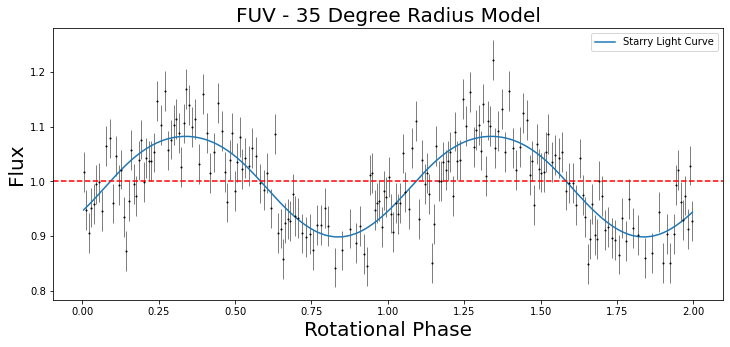

In [104]:
FUV_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('FUV - 35 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, FUV_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV_flux, yerr=FUV_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [105]:
residuals = (FUV_flux - FUV_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.9093346730829657

# FUV (1520 - 1715)

In [106]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTFUV(1520_1715).dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTFUV(1520_1715).dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

FUV3_flux = meanFlux
FUV3_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

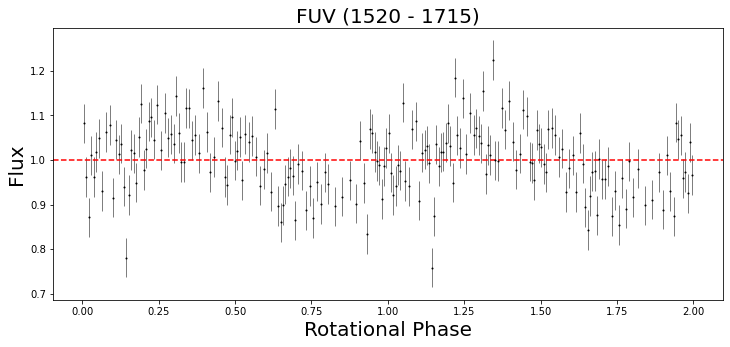

In [107]:
plt.figure(figsize=(12, 5))

plt.title('FUV (1520 - 1715)', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV3_flux, yerr=FUV3_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [108]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.9999)
    radius = 35
    lat = 50.64638
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 39.35362
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=FUV3_flux_err, observed=FUV3_flux)

In [109]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -330.70959026173824 -> 227.70494957692264


In [110]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.44579
lon          66.84306


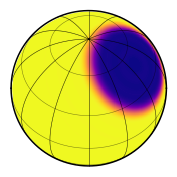

In [111]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.44579, radius=35, lat=50.64638, lon=66.84306)
map.inc = 39.35362
map.show()

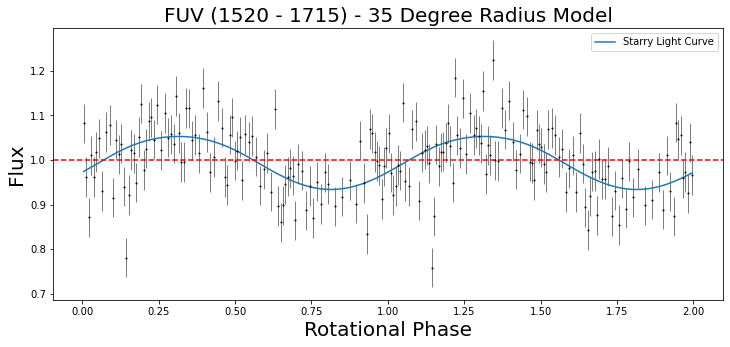

In [112]:
FUV3_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('FUV (1520 - 1715) - 35 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, FUV3_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV3_flux, yerr=FUV3_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [113]:
residuals = (FUV3_flux - FUV3_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

2.150976492538658

# FUV (1330 - 1520)

In [114]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTFUV(1330_1520).dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTFUV(1330_1520).dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

FUV2_flux = meanFlux
FUV2_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

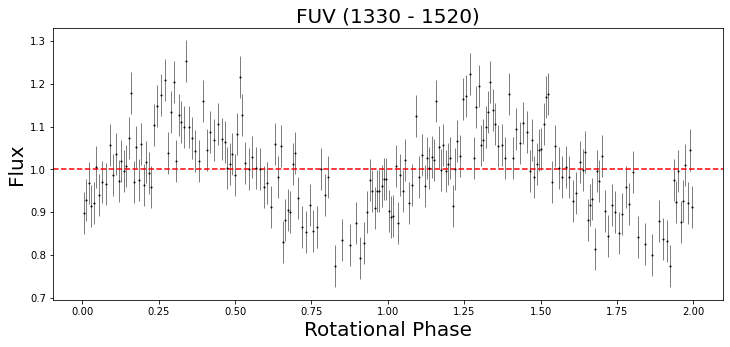

In [115]:
plt.figure(figsize=(12, 5))

plt.title('FUV (1330 - 1520)', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV2_flux, yerr=FUV2_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [116]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.9999)
    radius = 35
    lat = 50.64638
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 39.35362
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=FUV2_flux_err, observed=FUV2_flux)

In [117]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Desired error not necessarily achieved due to precision loss.
logp: -128.79789458036876 -> 257.8478269562594


In [118]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.76041
lon          56.15748


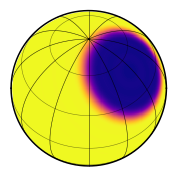

In [119]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.76041, radius=35, lat=50.64638, lon=56.15748)
map.inc = 39.35362
map.show()

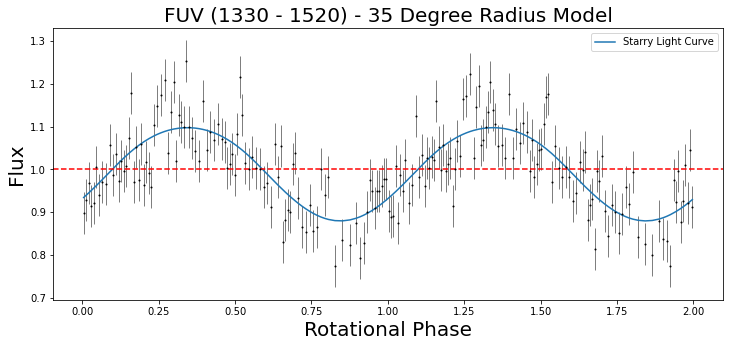

In [120]:
FUV2_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('FUV (1330 - 1520) - 35 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, FUV2_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV2_flux, yerr=FUV2_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [121]:
residuals = (FUV2_flux - FUV2_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.6268413276088636

# FUV (1120 - 1330)

In [122]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTFUV(1120_1330).dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTFUV(1120_1330).dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

FUV1_flux = meanFlux
FUV1_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

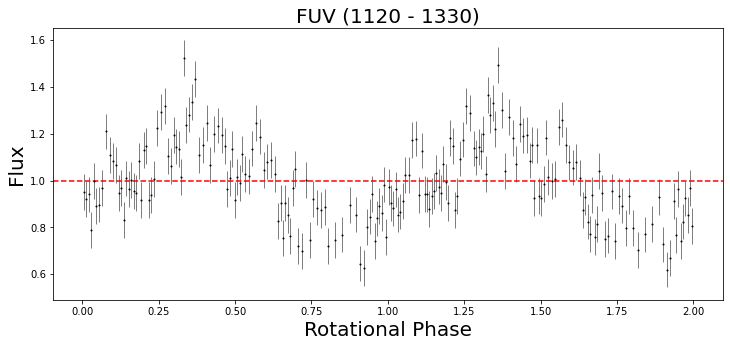

In [123]:
plt.figure(figsize=(12, 5))

plt.title('FUV (1120 - 1330)', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV1_flux, yerr=FUV1_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [124]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.9999)
    radius = 35
    lat = 50.64638
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 39.35362
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=FUV1_flux_err, observed=FUV1_flux)

In [125]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -94.84842914832734 -> 93.4064330694409


In [126]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.99196
lon          50.38877


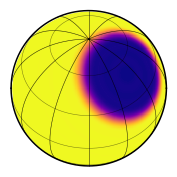

In [127]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.99196, radius=35, lat=50.64638, lon=50.38877)
map.inc = 39.35362
map.show()

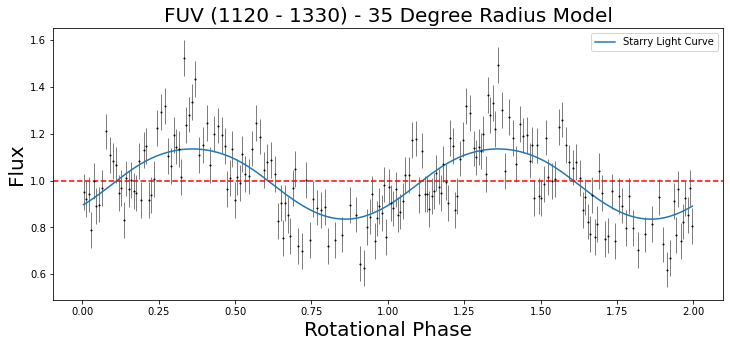

In [128]:
FUV1_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('FUV (1120 - 1330) - 35 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, FUV1_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV1_flux, yerr=FUV1_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [129]:
residuals = (FUV1_flux - FUV1_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

2.3784474150900916